# parameter tuned
reference : https://www.kaggle.com/znyksh/fork-lightgbm-with-simple-features/versions#base=4143658&new=4153250

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

import time
import gc
from tqdm import tqdm

In [2]:
st = time.time()
df = pd.read_csv('./new_feature_by_kageyama_feature_matrix_noIDs.csv')
time.time() - st

129.07359218597412

In [3]:
df = df.drop('SK_ID_CURR', axis=1)

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
categorical_feats = [f for f in df.columns if df[f].dtype == 'object']
for col in tqdm(categorical_feats):
    if col == 'set' :
        continue
    df[col] = df[col].astype('str')
    le.fit(df[col])
    df[col] = le.transform(df[col])
train_df = df.loc[df['set'] == 'train'] .drop('set', axis = 1)
test_df = df.loc[df['set'] == 'test'] .drop(['set', 'TARGET'], axis=1)

del df
gc.collect()

100%|██████████| 39/39 [00:43<00:00,  1.11s/it]


36

In [5]:
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])

feature_importance_df = pd.DataFrame()
y = train_df['TARGET'].copy()
X = train_df.drop('TARGET', axis = 1)


feats =  list(X.columns)

folds = KFold(n_splits=25, shuffle=True, random_state=2018)
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X)):
    train_X, train_y = X.iloc[trn_idx], y.iloc[trn_idx]
    valid_X, valid_y = X.iloc[val_idx], y.iloc[val_idx]

    clf = LGBMClassifier(
        n_estimators=4000,
        learning_rate=0.02,
        num_leaves=32,
        colsample_bytree=.8,
        subsample=.87,
        max_depth=8,
        reg_alpha=.0415,
        reg_lambda=.0735,
        min_split_gain=.02,
        min_child_weight=40,
        silent=-1,
        verbose=-1,
    )

    clf.fit(train_X, train_y, 
            eval_set= [(train_X, train_y), (valid_X, valid_y)], 
            eval_metric='auc', verbose=100, early_stopping_rounds=100  #30
           )

    oof_preds[val_idx] = clf.predict_proba(valid_X, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test_df, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[val_idx])))
    del clf, train_X, train_y, valid_X, valid_y
    gc.collect()

print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 

sub = pd.read_csv('../input/sample_submission.csv')
sub['TARGET'] = sub_preds



Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.758766	valid_1's auc: 0.751971
[200]	training's auc: 0.780869	valid_1's auc: 0.764686
[300]	training's auc: 0.79807	valid_1's auc: 0.774438
[400]	training's auc: 0.809729	valid_1's auc: 0.779476
[500]	training's auc: 0.818902	valid_1's auc: 0.782489
[600]	training's auc: 0.826994	valid_1's auc: 0.783755
[700]	training's auc: 0.833981	valid_1's auc: 0.784831
[800]	training's auc: 0.840603	valid_1's auc: 0.78592
[900]	training's auc: 0.84636	valid_1's auc: 0.786711
[1000]	training's auc: 0.851918	valid_1's auc: 0.78725
[1100]	training's auc: 0.857067	valid_1's auc: 0.787744
[1200]	training's auc: 0.861734	valid_1's auc: 0.787783
[1300]	training's auc: 0.86643	valid_1's auc: 0.788034
[1400]	training's auc: 0.871036	valid_1's auc: 0.788381
[1500]	training's auc: 0.875265	valid_1's auc: 0.788493
[1600]	training's auc: 0.879333	valid_1's auc: 0.788859
[1700]	training's auc: 0.883103	valid_1's auc: 0.789087

[700]	training's auc: 0.834215	valid_1's auc: 0.783928
[800]	training's auc: 0.840561	valid_1's auc: 0.784869
[900]	training's auc: 0.846408	valid_1's auc: 0.785639
[1000]	training's auc: 0.851969	valid_1's auc: 0.785924
[1100]	training's auc: 0.857163	valid_1's auc: 0.786667
[1200]	training's auc: 0.86194	valid_1's auc: 0.786938
[1300]	training's auc: 0.866555	valid_1's auc: 0.787274
[1400]	training's auc: 0.871035	valid_1's auc: 0.787339
[1500]	training's auc: 0.875351	valid_1's auc: 0.787708
[1600]	training's auc: 0.879383	valid_1's auc: 0.787709
Early stopping, best iteration is:
[1544]	training's auc: 0.877126	valid_1's auc: 0.788
Fold  8 AUC : 0.788000
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.759479	valid_1's auc: 0.746687
[200]	training's auc: 0.781055	valid_1's auc: 0.75897
[300]	training's auc: 0.798421	valid_1's auc: 0.768859
[400]	training's auc: 0.81005	valid_1's auc: 0.774247
[500]	training's auc: 0.81932	valid_1's auc: 0.77735

Early stopping, best iteration is:
[1610]	training's auc: 0.879138	valid_1's auc: 0.792092
Fold 15 AUC : 0.792092
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.758623	valid_1's auc: 0.749059
[200]	training's auc: 0.780251	valid_1's auc: 0.765648
[300]	training's auc: 0.797741	valid_1's auc: 0.778294
[400]	training's auc: 0.809265	valid_1's auc: 0.784234
[500]	training's auc: 0.81856	valid_1's auc: 0.788086
[600]	training's auc: 0.826615	valid_1's auc: 0.79031
[700]	training's auc: 0.833843	valid_1's auc: 0.791959
[800]	training's auc: 0.840267	valid_1's auc: 0.793287
[900]	training's auc: 0.846206	valid_1's auc: 0.794036
[1000]	training's auc: 0.851486	valid_1's auc: 0.794373
[1100]	training's auc: 0.856817	valid_1's auc: 0.794668
[1200]	training's auc: 0.861704	valid_1's auc: 0.795075
[1300]	training's auc: 0.86635	valid_1's auc: 0.795333
[1400]	training's auc: 0.87082	valid_1's auc: 0.795466
[1500]	training's auc: 0.875201	valid_1's auc: 0.795

[400]	training's auc: 0.809608	valid_1's auc: 0.780576
[500]	training's auc: 0.818684	valid_1's auc: 0.783526
[600]	training's auc: 0.826836	valid_1's auc: 0.785918
[700]	training's auc: 0.833835	valid_1's auc: 0.786796
[800]	training's auc: 0.840397	valid_1's auc: 0.787683
[900]	training's auc: 0.846107	valid_1's auc: 0.788281
[1000]	training's auc: 0.851544	valid_1's auc: 0.788829
[1100]	training's auc: 0.856997	valid_1's auc: 0.789135
[1200]	training's auc: 0.861697	valid_1's auc: 0.789373
[1300]	training's auc: 0.86631	valid_1's auc: 0.789714
[1400]	training's auc: 0.870646	valid_1's auc: 0.790252
[1500]	training's auc: 0.874916	valid_1's auc: 0.790721
[1600]	training's auc: 0.879012	valid_1's auc: 0.790695
Early stopping, best iteration is:
[1556]	training's auc: 0.877253	valid_1's auc: 0.790912
Fold 24 AUC : 0.790912
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.759137	valid_1's auc: 0.747579
[200]	training's auc: 0.780549	valid_1's auc: 0

In [6]:
sub.to_csv('./kageyama_feature_matrix_25cv_tuned_by_Ivan_sub_noIDs.csv', index=None)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()


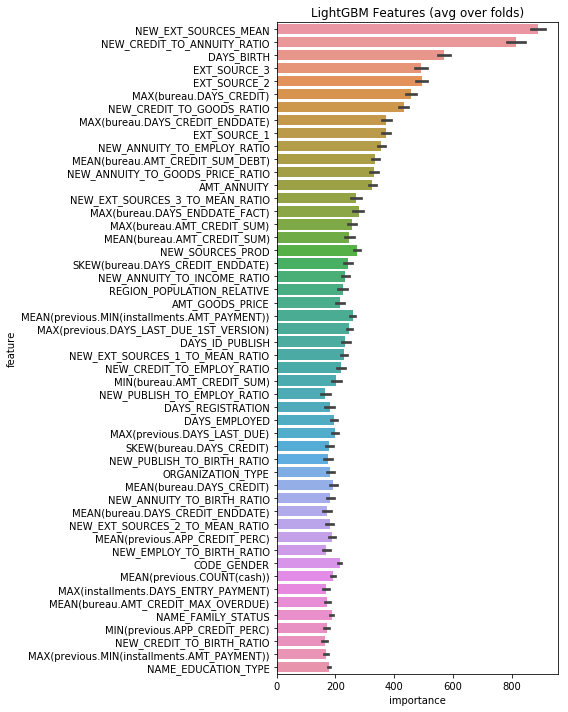

In [8]:
display_importances(feature_importance_df)

In [9]:
time.time() - st

22797.790402650833

In [10]:
feature_importances = feature_importance_df[["feature", "importance"]].groupby("feature").mean()

def norm_feature_importances(df, threshold = 0.95):
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

norm_feature_importances = norm_feature_importances(feature_importances)

df = pd.read_csv('./new_feature_by_kageyama_feature_matrix_noIDs.csv')
# Threshold for cumulative importance
for threshold in [0.98, 0.96, 0.94, 0.92, 0.9]:

    # Extract the features to keep
    unimportant_features = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] >= threshold]['feature'])    
    df.drop(unimportant_features, axis=1).to_csv('./kageyama_feature_matrix_{}.csv'.format(threshold * 100),  index=None)

637 features required for 0.95 of cumulative importance
